# Alzheimer's Prediction (Multi-Class) - Random Forest

### Variable Descriptions
* `directory.id`	Id assigned to imaging directories. Not from LONi data
* `Subject (PTID)`	Participant ID
* `RID`	Participant roster ID
* `Image.Data.ID`	MRI ID
* `Modality`	Image type
* `Visit`	1=screening scan
* `Acq.Date`	MRI date
* `DX.bl`	Diagnosis at baseline
* `EXAMDATE`	Examination Date
* `AGE`	    Age at baseline
* `PTGENDER`	Sex
* `PTEDUCAT`	Years of Education
* `PTETHCAT`	Ethnicity
* `PTRACCAT`	Race
* `APOE4`	APOE4 genotype
* `MMSE`	MMSE score on cognitive test
* `imputed_genotype`	Challenge specific designation, TRUE=has imputed genotypes
* `APOE Genotype`	APOE allele 1 and allele 2 genotypes
* `Dx Codes for Submission`	The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import os

In [2]:
#Read data
dat = pd.read_csv('AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

#Check NA values, 1 NA for imputed_genotype
# dat.isnull().sum()

## Train/Test Split
* `X_train` and `y_train` will further split into train/valid splits using K-fold CV
* `X_test` and `y_test` will be held out

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

print('X_train:', X_train.shape, '\ty_train:', y_train.shape)
print('X_test:', X_test.shape, '\ty_test:', y_test.shape)
num_test = X_test.shape[0]

X_train: (501, 22) 	y_train: (501,)
X_test: (126, 22) 	y_test: (126,)


##  Random Forest

In [12]:

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score

In [15]:
rf_clf = RandomForestClassifier(n_neighbors=10)
print('Validation Accuracy = ', format(cross_val_score(knn_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  68.06%


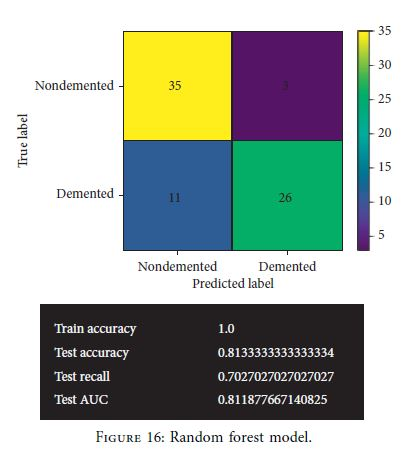

### Tangent: Evaluate feature importances given by Random Forest

### Remember:
* PTGENDER: (Male, Female)
* PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
* PTRACCAT: (White, Black, Asian)
* APOE4: (0, 1, 2)
* APOE4 Genotype: (22, 23, 24, 33, 34, 44)
* imputed_genotype (True, False)

In [17]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Conclusion: Feature Importance
* Cognitive test score (MMSE), age (AGE), years of education (PTEDUCAT) are considered the three most important features by far
* Interestingly, the genetic information (APOE4 and APOE4 Genotype) was not considered very important by the model

### Analyze misclassifications

In [25]:
misclassified_index = (log_clf_preds != y_test)

X_misclassified = X_test[misclassified_index]
y_misclassified = y_test[misclassified_index]
preds_misclassified = log_clf_preds[misclassified_index]

X_misclassified.head()

,AGE,PTEDUCAT,MMSE,False,True,"2,2","2,3","2,4","3,3","3,4",...,Male,0,1,2,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White
486,87.9,18,24,1,0,0,0,0,1,0,...,1,1,0,0,0,1,0,1,0,0
502,56.2,18,24,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
616,74.6,16,24,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
513,69.7,14,25,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
480,59.8,13,30,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


In [27]:
print('Model over-estimated severity of cognitive problems:', over_estimate)
print('Model under-estimated severity of cognitive problems:', under_estimate)
print('Model was way off (total miss):', total_miss)

Model over-estimated severity of cognitive problems: 17
Model under-estimated severity of cognitive problems: 15
Model was way off (total miss): 0


### Conclusion
* Fairly even misclassification, No total misses
* Probably want to **lower** `under-estimated`. Would be willing to sacrifice accuracy to get a more conservative model.
* e.g. **False Negative:** Predicting cognitively normal (CN) when a patient has Alzheimer's (AD) would be much worse than predicting AD when a patient is normal (CN).

### Look at distribution of 3 most important vars: AGE, MMSE, PTEDUCAT in misclassified examples
* means for entire dataset = `75, 26.9, 15.6`
* distributions looks relatively similar to that of entire data set. No obvious discrepancy 

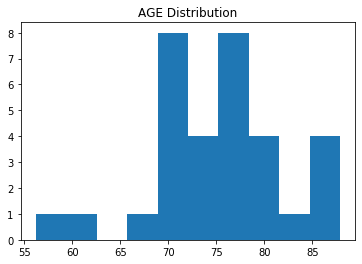

count    32.000000
mean     75.150000
std       6.958077
min      56.200000
25%      70.875000
50%      75.450000
75%      78.500000
max      87.900000
Name: AGE, dtype: float64


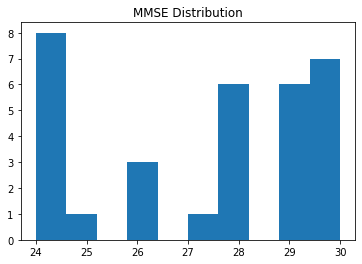

count    32.000000
mean     27.312500
std       2.334005
min      24.000000
25%      24.750000
50%      28.000000
75%      29.000000
max      30.000000
Name: MMSE, dtype: float64


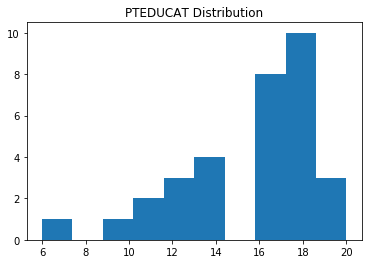

count    32.000000
mean     15.531250
std       3.321333
min       6.000000
25%      13.000000
50%      16.000000
75%      18.000000
max      20.000000
Name: PTEDUCAT, dtype: float64


In [29]:
# DRY unless you're a data scientist
for var in ['AGE', 'MMSE', 'PTEDUCAT']:
    plt.hist(X_misclassified[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X_misclassified[var].describe())